In [2]:
import epitomes
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

In [3]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

def gmm_aic_score(estimator, X):
    """Callable to pass to gridsearch that will use the AIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.aic(X)

def get_df_bic(grid_search):

    """
    Takes the result of the BIC grid search and creates a DataFrame
    that can be used to visualise the optimal number of k.
    """

    df_bic = pd.DataFrame(grid_search.cv_results_)[
        ["param_n_components", "param_covariance_type", "mean_test_score"]
        ]

    # re-invert the sign so we get the actual IC scores
    df_bic["mean_test_score"] = -df_bic["mean_test_score"]

    df_bic = df_bic.rename(
        columns={
            "param_n_components": "Number of components",
            "param_covariance_type": "Type of covariance",
            "mean_test_score": "BIC score",
        }
    )

    return df_bic

def get_df_aic(grid_search):

    """
    Takes the result of the AIC grid search and creates a DataFrame
    that can be used to visualise the optimal number of k.
    """

    df_aic = pd.DataFrame(grid_search.cv_results_)[
        ["param_n_components", "param_covariance_type", "mean_test_score"]
        ]

    # re-invert the sign so we get the actual IC scores
    df_aic["mean_test_score"] = -df_aic["mean_test_score"]

    df_aic = df_aic.rename(
        columns={
            "param_n_components": "Number of components",
            "param_covariance_type": "Type of covariance",
            "mean_test_score": "AIC score",
        }
    )

    return df_aic

In [4]:
epitome_texts, epitome_numbers = epitomes.load_epitomes('../epitomes')

In [6]:
with open('csvfiles/overlap_epitome_numbers.txt', 'r', encoding='utf-8') as f:
    nums = [int(num) for num in f.readlines()]

In [8]:
overlap_transcriptions = list(set(epitome_numbers).intersection(set(nums)))
overlap_transcriptions_idx = [i for i in range(len(epitome_numbers)) if epitome_numbers[i] in overlap_transcriptions]

In [9]:
# load the style vectors from csv files
path = 'csvfiles'
tfidf_dict = {}
for filename in os.listdir(path):
    if filename.startswith('tfidf'):
        ngram, rank = re.findall('\d+', filename)
        ngram = int(ngram)
        rank = int(rank)
        if ngram in tfidf_dict:
            tfidf_dict[ngram][rank] = np.genfromtxt(os.path.join(path, filename), delimiter=',')
        else:
            tfidf_dict[ngram] = {}
            tfidf_dict[ngram][rank] = np.genfromtxt(os.path.join(path, filename), delimiter=',')

In [10]:
overlap_tfidf_dict = {}
for n in tfidf_dict:
    overlap_tfidf_dict[n] = {}
    for r in tfidf_dict[n]:
        overlap_tfidf_dict[n][r] = tfidf_dict[n][r][overlap_transcriptions_idx]

In [11]:
grid_search_dict = {}
for ngram in tqdm(overlap_tfidf_dict):
    grid_search_dict[ngram] = {}
    for rank in tqdm(overlap_tfidf_dict[ngram]):
        grid_search_dict[ngram][rank] = {}
        X = overlap_tfidf_dict[ngram][rank]
        param_grid = {
            "n_components": range(1, 7),
            "covariance_type": ["spherical", "tied", "diag", "full"],
        }
        grid_search_bic = GridSearchCV(
            GaussianMixture(random_state=42), param_grid=param_grid, scoring=gmm_bic_score
        )

        grid_search_bic.fit(X)
        df_bic = get_df_bic(grid_search_bic)
        grid_search_dict[ngram][rank]['bic'] = df_bic

        grid_search_aic = GridSearchCV(
            GaussianMixture(random_state=42), param_grid=param_grid, scoring=gmm_aic_score
        )

        grid_search_aic.fit(X)
        df_aic = get_df_aic(grid_search_aic)
        grid_search_dict[ngram][rank]['aic'] = df_aic

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

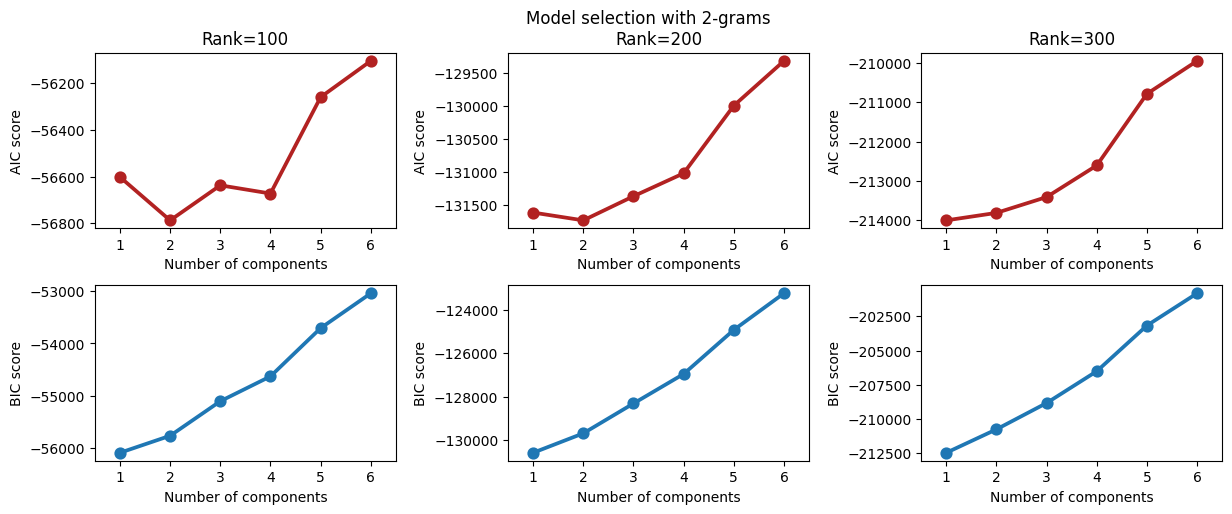

In [12]:
n = 2
fig, axes = plt.subplots(2, 3)
fig.set_size_inches(12, 5)
fig.suptitle(f'Model selection with {n}-grams')
plt.tight_layout(w_pad=5, h_pad=2)

for i, r in enumerate(sorted(tfidf_dict[n])):

    df_aic = grid_search_dict[n][r]['aic']
    aic_spher = grid_search_dict[n][r]['aic'][grid_search_dict[n][r]['aic']['Type of covariance'] == 'spherical']

    df_bic = grid_search_dict[n][r]['bic']
    bic_spher = grid_search_dict[n][r]['bic'][grid_search_dict[n][r]['bic']['Type of covariance'] == 'spherical']

    sns.pointplot(
        data=df_aic.loc[(df_aic['Type of covariance'] == 'spherical')],
        x="Number of components",
        y="AIC score",
        color='firebrick',
        ax=axes[0][i]
    )

    axes[0][i].set_title(f'Rank={r}')

    sns.pointplot(
        data=df_bic.loc[(df_bic['Type of covariance'] == 'spherical')],
        x="Number of components",
        y="BIC score",
        ax=axes[1][i]
    )

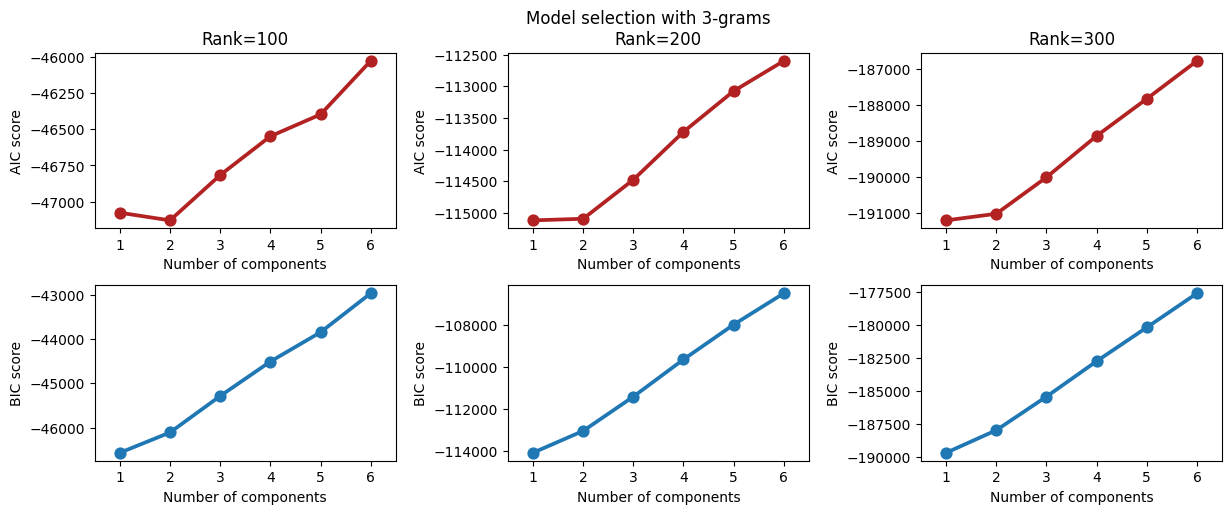

In [13]:
n = 3
fig, axes = plt.subplots(2, 3)
fig.set_size_inches(12, 5)
fig.suptitle(f'Model selection with {n}-grams')
plt.tight_layout(w_pad=5, h_pad=2)

for i, r in enumerate(sorted(tfidf_dict[n])):

    df_aic = grid_search_dict[n][r]['aic']
    aic_spher = grid_search_dict[n][r]['aic'][grid_search_dict[n][r]['aic']['Type of covariance'] == 'spherical']

    df_bic = grid_search_dict[n][r]['bic']
    bic_spher = grid_search_dict[n][r]['bic'][grid_search_dict[n][r]['bic']['Type of covariance'] == 'spherical']

    sns.pointplot(
        data=df_aic.loc[(df_aic['Type of covariance'] == 'spherical')],
        x="Number of components",
        y="AIC score",
        color='firebrick',
        ax=axes[0][i]
    )

    axes[0][i].set_title(f'Rank={r}')

    sns.pointplot(
        data=df_bic.loc[(df_bic['Type of covariance'] == 'spherical')],
        x="Number of components",
        y="BIC score",
        ax=axes[1][i]
    )

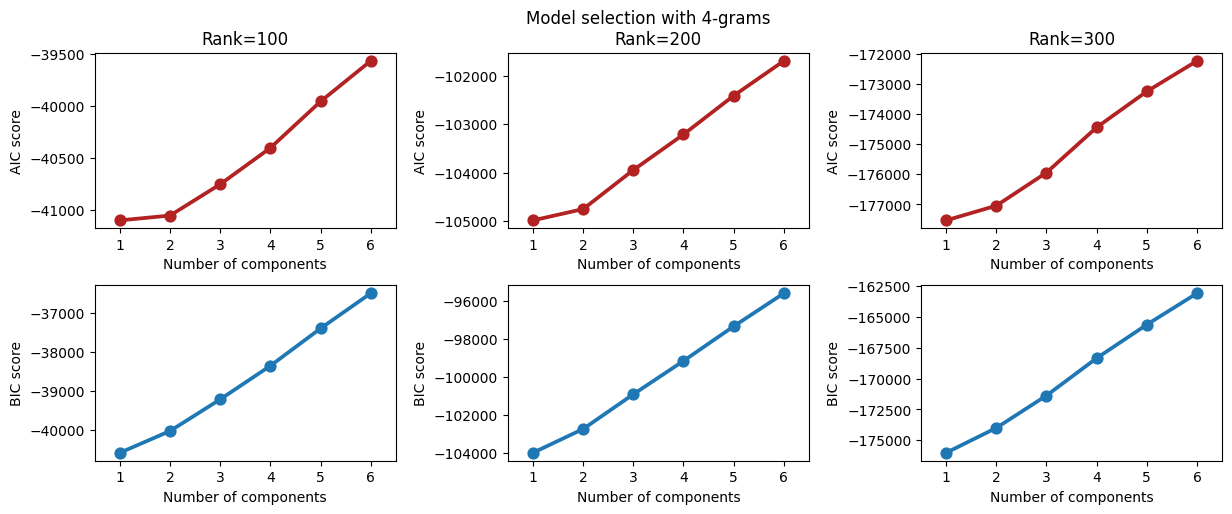

In [15]:
n = 4
fig, axes = plt.subplots(2, 3)
fig.set_size_inches(12, 5)
fig.suptitle(f'Model selection with {n}-grams')
plt.tight_layout(w_pad=5, h_pad=2)

for i, r in enumerate(sorted(tfidf_dict[n])):

    df_aic = grid_search_dict[n][r]['aic']
    aic_spher = grid_search_dict[n][r]['aic'][grid_search_dict[n][r]['aic']['Type of covariance'] == 'spherical']

    df_bic = grid_search_dict[n][r]['bic']
    bic_spher = grid_search_dict[n][r]['bic'][grid_search_dict[n][r]['bic']['Type of covariance'] == 'spherical']

    sns.pointplot(
        data=df_aic.loc[(df_aic['Type of covariance'] == 'spherical')],
        x="Number of components",
        y="AIC score",
        color='firebrick',
        ax=axes[0][i]
    )

    axes[0][i].set_title(f'Rank={r}')

    sns.pointplot(
        data=df_bic.loc[(df_bic['Type of covariance'] == 'spherical')],
        x="Number of components",
        y="BIC score",
        ax=axes[1][i]
    )